In [ ]:
!pip install datasets
!pip install transformers[sentencepiece]
!pip install peft
!pip install evaluate
!pip install rouge_score

# NLP, DS-поток
## Задание 4
### Parameter-Efficient Fine-Tuning.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


**Баллы за задание.**
  * Работа с данными &mdash; 10 баллов;
  * Обучение моделей &mdash; 80 баллов;
  * Оценка качества &mdash; 40 баллов;
  * Сравнение моделей &mdash; 20 баллов.


In [1]:
# Bot check

# HW_ID: ds_nlp4
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import transformers
import evaluate

import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, palette="Set2")

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset

from transformers import (
    AutoTokenizer,
    AutoModel,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    default_data_collator
)

from transformers import T5ForConditionalGeneration, T5Tokenizer

from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    TaskType,
    LoraConfig
)

from tqdm.auto import tqdm
from pathlib import Path

from sklearn.model_selection import train_test_split

## Описание задачи

В этом домашнем задании мы будем работать c моделью [ruT5](https://habr.com/ru/company/sberbank/blog/567776/) на данных новостей с портала [Газета.Ru](https://www.kaggle.com/datasets/phoenix120/gazeta-summaries) над задачей суммаризации новостей. Обычно при обсуждении задачи суммаризации выделяют два основных подхода:
* **Экстрактивная суммаризация.** В этом случае из исходного текста выделяются наиболее важные фрагменты, ключевые слова, которые и будут являться сжатым содержанием.
* **Абстрактивная суммаризация.** Этот подход отличается тем, что краткое содержание исходного текста порождается некоторой генеративной моделью.

В этом домашнем задании мы решаем задачу абстрактивной суммаризации. При решении задачи мы не будем обучать модель целиком, а попробуем применить некоторые подходы эффективного по параметрам обучения с помощью библиотеки [PEFT](https://github.com/huggingface/peft).

Надо оговориться, что идея применения T5-based архитектур для решения задач суммаризации на русском языке [не нова](https://sbercloud.ru/ru/datahub/rugpt3family/summarizer). Основной смысл задания состоит в том, чтобы реализовать полный пайплайна частичного обучения модели с помощью библиотеки `peft` и оценить получившееся качество. При выполнении задания **не разрешается** использовать предобученные на этой задаче модели, например [такую](https://huggingface.co/IlyaGusev/rut5_base_sum_gazeta). Мы будем использовать модели, обученные только на задачу денойзинга, то есть `ruT5-base` или, при наличии ресурсов, `ruT5-large`.

Рассмотрим пример генерации с помощью `ruT5-base` для задачи денойзинга или заполнения слотов. Для инференса `transformers` предоставляет удобный метод `.generate(...)`. В зависимоcти от переданных параметров можно генерировать  с использованием жадной стратегии, сэмплирования с температурой, top-k или top-p сэмплирования, а также использовать beam search. Рекомендуется ознакомиться с [постом](https://huggingface.co/blog/how-to-generate), в котором показаны примеры применения различных стратегий декодирования. Если у вас есть некоторые сомнения, связанные с пониманием работы полноценного трансформера с encoder-decoder архитектурой, то рекомендуется ознакомиться также с [этим](https://huggingface.co/blog/encoder-decoder#encoder-decoder) постом.

In [3]:
model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
tokenizer = T5Tokenizer.from_pretrained("ai-forever/ruT5-base")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
input_ids = tokenizer(
    "Снижение цен <extra_id_0> в Москве возможно только при <extra_id_1> " +
    "Это условие названо в аналитической заметке портала Новости <extra_id_2> ",
    return_tensors='pt'
)["input_ids"]

out_ids = model.generate(
    input_ids=input_ids,                 # послд-ть входных токенов, в нашем случае вход декодера
    max_length=64,                       # макс. длина ген. послед-ти
    eos_token_id=tokenizer.eos_token_id, # eos токен
    num_beams=5,                         # указываем num_beams - будет использован beam_search
)

tokenizer.decode(out_ids[0])

'<pad> <extra_id_0> на жилье <extra_id_1> соблюдении ряда условий. <extra_id_2> Москвы</s>'

Обратите внимание, что роль bos-токена играет `<pad>`. Далее, пропуски`<extra_id_X>` раскрываются в возможные фрагменты текста. В данном случае `<extra_id_0>`, `<extra_id_1>` и т.п. &mdash; это спец токены, которые которые модель должна заполнить, тем самым решая задачу денойзинга. Т.к. T5 &mdash; полноценный трансформер, на вход энкодера во время предобучения приходит текст с этими спец. токенами, а на вход декодера – те последовательности, что долны быть на месте спец. токенов.

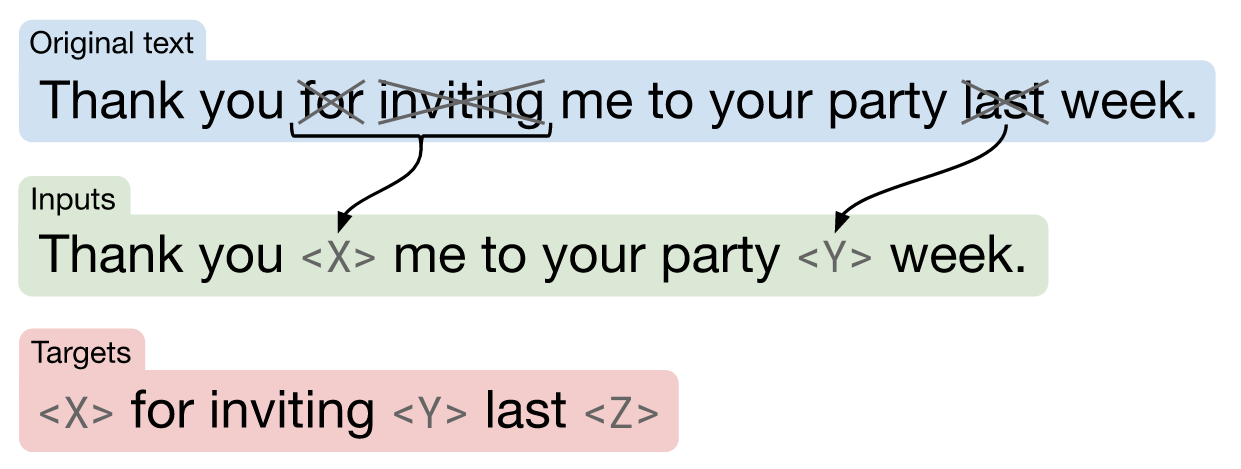

## Работа с данными

Теперь загрузим данные. Если при решении задания у вас возникнут проблемы из-за большого объема данных, например, не будет хватать оперативной памяти, то **можете взять подвыборку разумного** размера из обучающего и валидационного датасета.

In [5]:
dataset = load_dataset("IlyaGusev/gazeta", revision="v1.0", trust_remote_code=True)

Структура датасета

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title', 'date', 'url'],
        num_rows: 52400
    })
    test: Dataset({
        features: ['text', 'summary', 'title', 'date', 'url'],
        num_rows: 5770
    })
    validation: Dataset({
        features: ['text', 'summary', 'title', 'date', 'url'],
        num_rows: 5265
    })
})

Итак

In [7]:
train_data = dataset["train"]
val_data = dataset["validation"]

Посмотрим, из чего состоит обучающий пример. Нас будут интересовать поля `text`, `summary`.

In [8]:
train_data[13]

{'text': 'Российскому певцу Андрею Губину исполнилось 45 лет. Последнее время артист залег на дно и перестал радовать поклонников новыми хитами и полностью отказался от концертов. В одном из немногочисленных интервью, Губин жаловался на свое здоровье, указывая на проблемы нервной системы. По словам музыканта, врачи не уделили ему должного внимания, в связи с чем ему приходится бороться с проблемой самостоятельно. Продюсер «Ласкового мая» Андрей Разин рассказал о том, что он пытается помочь Губину. Разин подтвердил, что у звезды 90-х действительно серьезные проблемы, однако, по его мнению, это проблемы психического характера: «У Андрея серьезные проблемы с психикой. Ему мерещится, что у него постоянно чешется и болит лицо. Мы его водили по врачам, они ничего не нашли». Он также отметил, что с певцом стало очень тяжело говорить, поскольку тот стал чрезмерно вспыльчивым и ранимым, неадекватно воспринимая все попытки ему помочь, сообщает издание Bimru. По некоторой информации, покинув сцен

Выделим необходимые поля.

In [9]:
train_text = [value['text'] for value in train_data]
train_summary = [value['summary'] for value in train_data]

val_text = [value['text'] for value in val_data]
val_summary = [value['summary'] for value in val_data]

Соберем датасеты.

In [10]:
train_dataset = Dataset.from_dict({
    "text": train_text,
    "summary": train_summary
})

val_dataset = Dataset.from_dict({
    "text": val_text,
    "summary": val_summary
})

Распределения длин исходных текстов

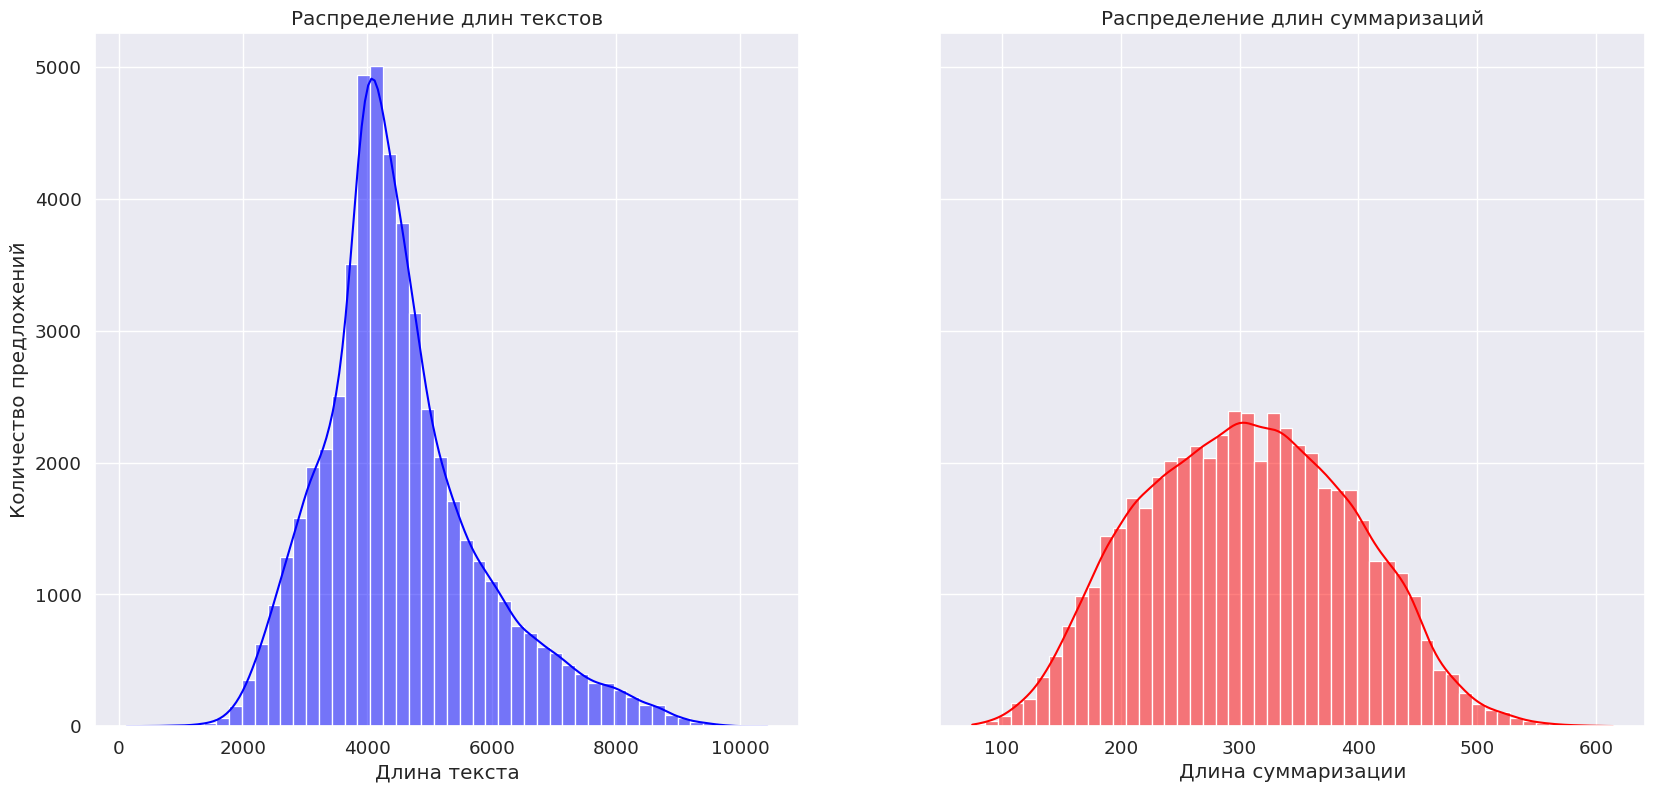

In [15]:
lens_text = [len(x["text"]) for x in train_dataset]
lens_summary = [len(x["summary"]) for x in train_dataset]

fig, axes = plt.subplots(1, 2, figsize=(20, 9), sharey=True)

sns.histplot(lens_text, bins=50, kde=True, color='blue', ax=axes[0])
axes[0].set_title("Распределение длин текстов")
axes[0].set_xlabel("Длина текста")
axes[0].set_ylabel("Количество предложений")

sns.histplot(lens_summary, bins=50, kde=True, color='red', ax=axes[1])
axes[1].set_title("Распределение длин суммаризаций")
axes[1].set_xlabel("Длина суммаризации")

plt.show()

И распределения длин токенов, по ним подберем параметр `max_length`

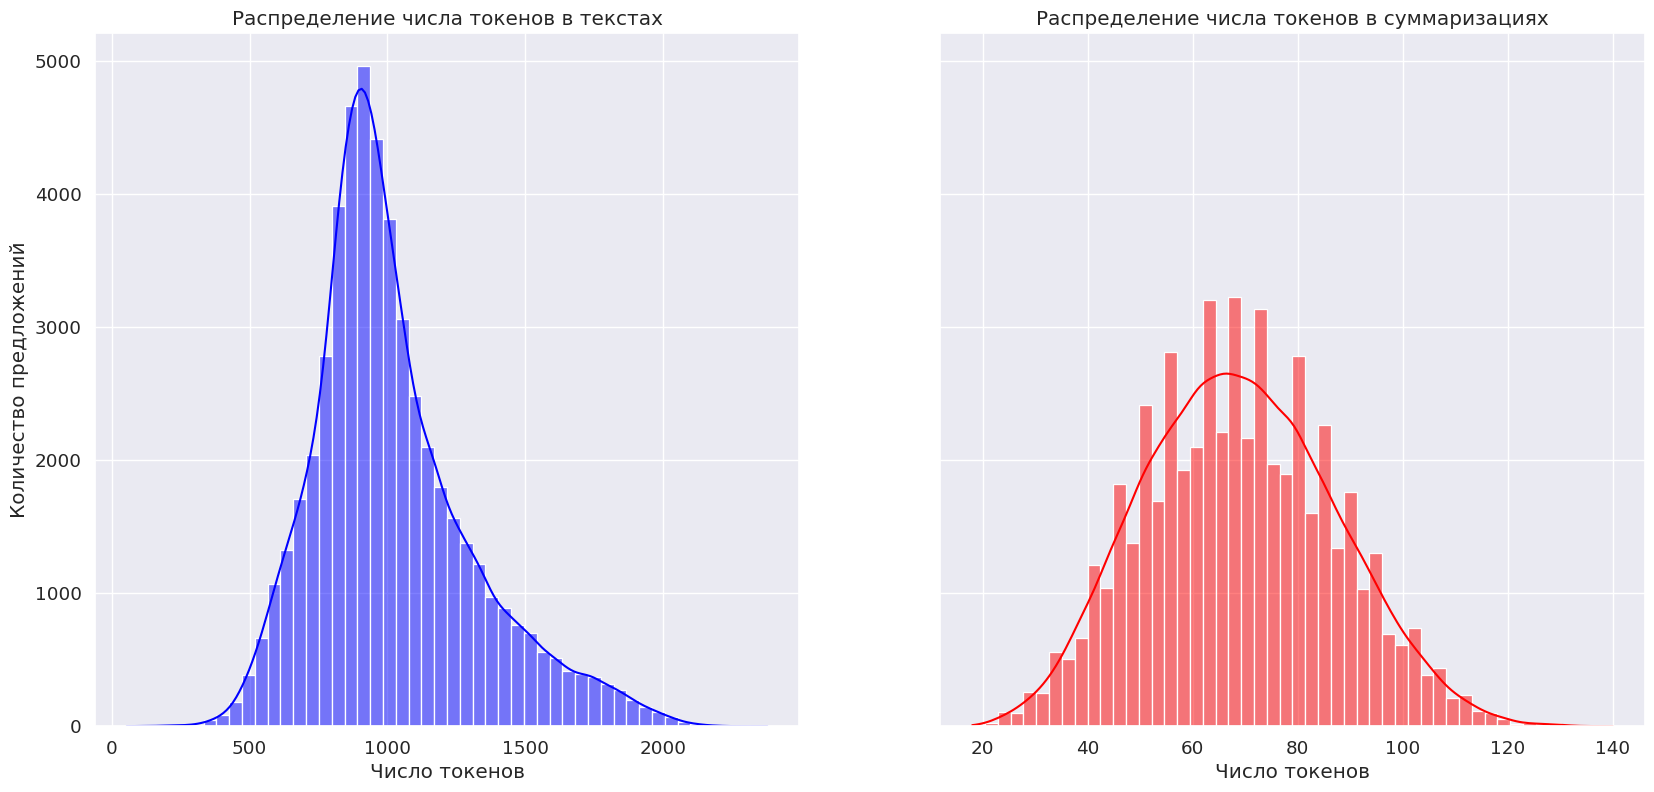

In [16]:
token_lens_text = [len(tokenizer(x["text"])["input_ids"]) for x in train_dataset]
token_lens_summary = [len(tokenizer(x["summary"])["input_ids"]) for x in train_dataset]

fig, axes = plt.subplots(1, 2, figsize=(20, 9), sharey=True)

sns.histplot(token_lens_text, bins=50, kde=True, color='blue', ax=axes[0])
axes[0].set_title("Распределение числа токенов в текстах")
axes[0].set_xlabel("Число токенов")
axes[0].set_ylabel("Количество предложений")

sns.histplot(token_lens_summary, bins=50, kde=True, color='red', ax=axes[1])
axes[1].set_title("Распределение числа токенов в суммаризациях")
axes[1].set_xlabel("Число токенов")

plt.show()

Напишем функцию для препроцессинга наших данных. Архитектурно модель `ruT5` &mdash; это полноценный трансформер. На вход модели будет поступать исходный текст новости, по которому она будет пытаться сгенерировать его сжатое саммари.

In [11]:
def preprocess_function(examples):
    """ Функция препроцессинга для обработки данных. """

    # выделим input / targets для модели
    inputs = examples["text"]
    targets = examples["summary"]
    # токенизируем новости, это вход энкодера
    # наша source-последовательность
    model_inputs = tokenizer(inputs,
                             max_length=500,
                             padding="max_length",
                             truncation=True,
                             return_tensors="pt")
    # токенизируем саммари, это входе декодера во время обучения
    # то есть наша target-последовательность
    labels = tokenizer(targets,
                       max_length=130,
                       padding="max_length",
                       truncation=True,
                       return_tensors="pt")
    # не будем считать лосс для паддинга
    # по умолчанию nn.CrossEntropy не учитыает в лоссе объекты с меткой -100
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100

    # сформируем вход для нашей модели
    model_inputs["labels"] = labels[0]
    model_inputs["input_ids"] = model_inputs["input_ids"][0]
    model_inputs["attention_mask"] = model_inputs["attention_mask"][0]
    return model_inputs

Применим препроцессинг к датасету. Обратите внимание, что паддинг мы сделали заранее. Понятно, что это не очень эффективно. При желании рекомендуется это исправить, то есть перенести паддинг на момент формирования батча в data collator. Заметим также, что саммари обычно гораздо меньше исходной новости, поэтому выставлять `max_length` следует аккуратно.

In [12]:
train_dataset = train_dataset.map(
    preprocess_function,
    num_proc=4,
    desc="Running tokenizer on train dataset...",
)

val_dataset =val_dataset .map(
    preprocess_function,
    num_proc=4,
    desc="Running tokenizer on train dataset...",
)

Running tokenizer on train dataset... (num_proc=4):   0%|          | 0/52400 [00:00<?, ? examples/s]

Running tokenizer on train dataset... (num_proc=4):   0%|          | 0/5265 [00:00<?, ? examples/s]

## Обучение моделей

В библиотеке [`PEFT`](https://github.com/huggingface/peft) представлены различные подходы к эффективному по параметрам обучению. Рассмотрим некоторые из них.

### LoRA

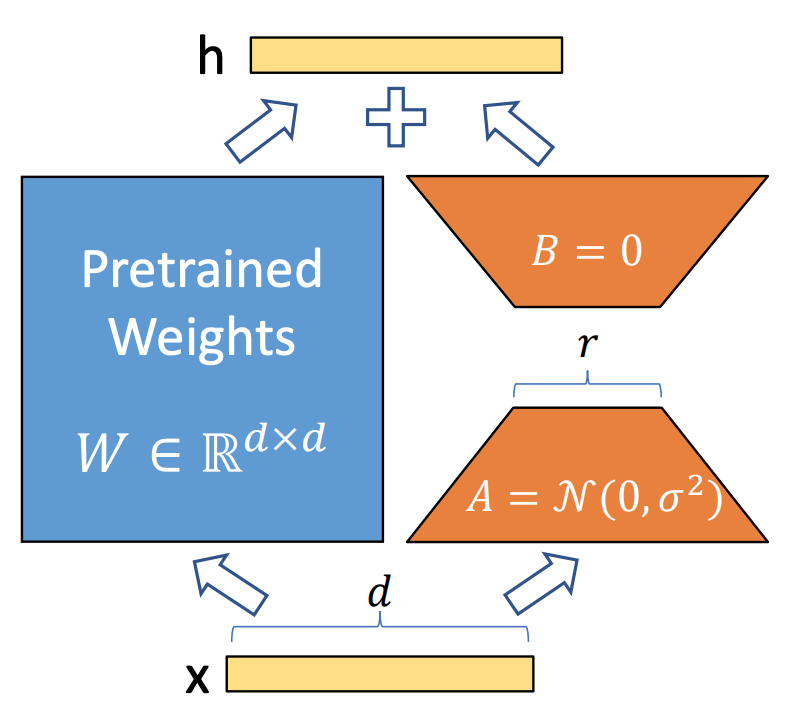

Позволяет повысить эффективность обучения посредством использования low-rank аппроксимации для матриц. Подробнее про метод и его использование можете прочитать [здесь](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora).

### IA^3
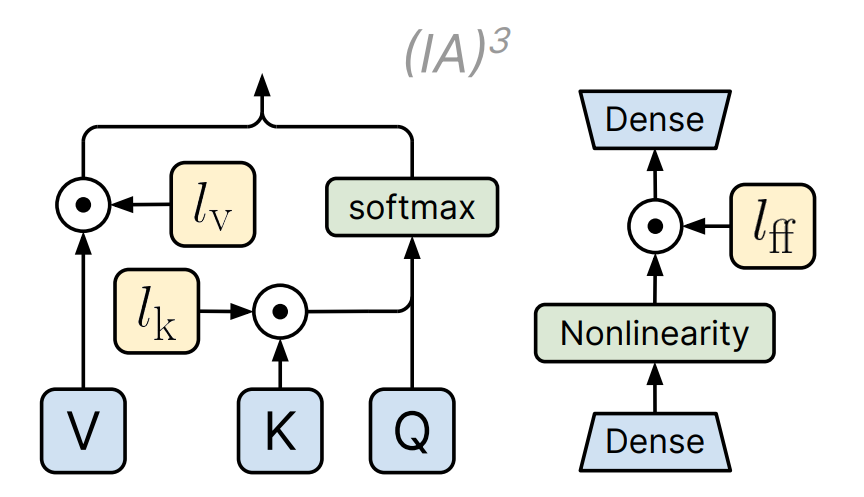

Метод IA3 (Infused Adapter by Inhibiting and Amplifying Inner Activations) добавляет в модель обучемые векторы $l_v$, $l_k$ и $l_{ff}$, которые умножаются (поэлементно) на соответствующие выходы слоев модели (см. изображение), таким образом добиваясь обучаемого рескейлинга. Обучение модели с таким адаптером получается даже эффективнее, чем обучение с использованием LoRA, и при этом результаты оказываются сопоставимыми с обычным fine-tuning.

Подробнее про подход можно прочитать [тут](https://huggingface.co/docs/peft/conceptual_guides/ia3).

Задать соотвествующий конфиг `peft`'a для нашей задачи можно так:
```
from peft import IA3Config, TaskType
peft_config = IA3Config(task_type=TaskType.SEQ_2_SEQ_LM, # задача seq2seq
                        inference_mode=False,
                        target_modules=...             # опционально можно задать  
                        feedforward_modules=...)       # target_modules / feedforward_modules
```

Обратите внимание, для LoRA также нужно будет указать верный `task_type`. На занятии мы рассматривали простую задачу классификации, а здесь же seq2seq.

Итак, вам предлагается обучить модели с использованием вышеописанных методов и сравнить их с обычным обычным fine-tuning'ом модели. Подумайте, какие преимущества и недостатки есть у каждого подхода.

Сравните модели при добавлении адаптер-слоев в различные модули. Попробуйте **2-3 варианта для каждого метода**. Для этого обратите внимание на аргументы `target_modules` и `feedforward_modules` во время конфигураций адаптеров. Мы используем модель на базе T5, по умолчанию в `peft` уже перечислены модули, в которые внедряются адаптеры для разных моделей. Например, для [LoRA](https://github.com/huggingface/peft/blob/9119b780ebac7859db5753ebad50d94ba803c99c/src/peft/utils/constants.py#L49) это `q` и `v` на каждом слое, а для [IA3](https://github.com/huggingface/peft/blob/9119b780ebac7859db5753ebad50d94ba803c99c/src/peft/utils/constants.py#L83)  &mdash; это `k`, `v` и `wo`.

Для LoRA попробуйте также различные 2-3 варианта гиперпараметра `r` через библиотеку `peft`. А также реализуйте свой кастомный слой-обертку в виде LoRA-адаптера над линейными слоями аттеншена в модулях `q` и `v`, обучите и сравните свою реализацию с реализацией через `peft`.

Начнем с собственной реализации LoRA-адаптера.


In [43]:
class LoRALayerWrapper(nn.Module):
    def __init__(self, original_layer, rank=8, alpha=16):
        super().__init__()
        self.original_layer = original_layer
        self.original_layer.requires_grad_(False)

        in_features = original_layer.in_features
        out_features = original_layer.out_features

        # Инициализация LoRA параметров
        self.lora_A = nn.Parameter(torch.empty(in_features, rank))
        self.lora_B = nn.Parameter(torch.empty(rank, out_features))
        self.scaling = alpha / rank # alpha и rank?

        # Инициализация весов
        nn.init.zeros_(self.lora_B)
        nn.init.normal_(self.lora_A, std=1/np.sqrt(rank))

    def forward(self, input):
        default_output = self.original_layer(input)
        
        lora_output = (input @ self.lora_A) @ self.lora_B
        lora_output *= self.scaling
        
        return default_output + lora_output

Проверим реализацию, сравнив ее с той, что предоставляет `peft`.

In [44]:
torch.manual_seed(42)
rank = 4
alpha = 32
dummy_input = torch.randn(1, 1, 768)

# Реализация через peft
peft_config = LoraConfig(
    r=rank,
    lora_alpha=alpha,
    target_modules=["q", "v"],
    lora_dropout=0.0,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
peft_model = get_peft_model(base_model, peft_config)

In [45]:
# возьмем один модуль для простого теста
q_layer_to_test = peft_model.base_model.encoder.block[0].layer[0].SelfAttention.q
# исходный линейный слой
base_linear_layer = q_layer_to_test.base_layer
# наша обертка
our_model = LoRALayerWrapper(base_linear_layer, rank=rank, alpha=alpha)

our_output = our_model(dummy_input)
peft_output = q_layer_to_test(dummy_input)
assert torch.allclose(our_output, peft_output, atol=1e-4), "Что-то не так с простым forward"

Тест выше совсем простой, т.к. из-за особенности инициализации изначально LoRA ничего не делает. Добавим чуть более сложный тест-кейс.

In [46]:
dummy_B = torch.randn_like(our_model.lora_B.data)

with torch.no_grad():
    # скопируем параметры
    our_model.lora_B.data.copy_(dummy_B)
    q_layer_to_test.lora_B.default.weight.data.copy_(dummy_B.T)
    our_model.lora_A.data.copy_(q_layer_to_test.lora_A.default.weight.data.T)

# forward + backward pass для реализаций
our_output = our_model(dummy_input)
our_loss = our_output.sum()
our_loss.backward()

peft_output = q_layer_to_test(dummy_input)
peft_loss = peft_output.sum()
peft_loss.backward()

In [47]:
our_grad_A = our_model.lora_A.grad
peft_grad_A = q_layer_to_test.lora_A.default.weight.grad.T

our_grad_B = our_model.lora_B.grad
peft_grad_B = q_layer_to_test.lora_B.default.weight.grad.T

assert torch.allclose(our_grad_A, peft_grad_A, atol=1e-4), "Расхождения градиентов для матрицы A"
assert torch.allclose(our_grad_B, peft_grad_B, atol=1e-4), "Расхождения градиентов для матрицы B"

Теперь напишем функцию для оборачивания модулей `q`, `v` через реализованный слой.

In [48]:
def inject_lora(model, rank, alpha):
    # Энкодер
    for encoder_block in model.encoder.block:
        self_attn = encoder_block.layer[0].SelfAttention
        self_attn.q = LoRALayerWrapper(self_attn.q, rank, alpha)
        self_attn.v = LoRALayerWrapper(self_attn.v, rank, alpha)

    # Декодер
    for decoder_block in model.decoder.block:
        # Self attention
        self_attn = decoder_block.layer[0].SelfAttention
        self_attn.q = LoRALayerWrapper(self_attn.q, rank, alpha)
        self_attn.v = LoRALayerWrapper(self_attn.v, rank, alpha)

        # Cross attention
        cross_attn = decoder_block.layer[1].EncDecAttention
        cross_attn.q = LoRALayerWrapper(cross_attn.q, rank, alpha)
        cross_attn.v = LoRALayerWrapper(cross_attn.v, rank, alpha)


    # Замораживаем все параметры, размораживаем только LoRA-матрицы
    for name, param in model.named_parameters():
        param.requires_grad = "lora" in name

    return model

Отлично, теперь можно приступить к экспериментам. Не забудьте сравнить свою реализацию LoRA c аналогичной через `peft`.

In [19]:
train_dataset = train_dataset.remove_columns(["text", "summary"])
val_dataset = val_dataset.remove_columns(["text", "summary"])

In [20]:
def get_subset(dataset, subset_fraction=0.25, seed=42):
    np.random.seed(seed)
    dataset_size = len(dataset)
    subset_size = int(subset_fraction * dataset_size)
    indices = np.random.choice(dataset_size, subset_size, replace=False)
    return dataset.select(indices)

train_dataset_sub = get_subset(train_dataset)
val_dataset_sub = get_subset(val_dataset)

Функция для обучения

In [34]:
from math import ceil

def train_and_evaluate(model, config_name, hyperparams, train_data, val_data):
    batch_size = 8
    total_steps = len(train_data) // batch_size
    half_epoch_steps = ceil(total_steps * 0.5)
    
    training_args = TrainingArguments(
        output_dir=f"./results/{config_name}_r{hyperparams['r']}_a{hyperparams['alpha']}",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        max_steps=half_epoch_steps,
        eval_steps=100,
        logging_steps=50,
        save_steps=100,
        eval_strategy="steps",
        save_strategy="steps",
        logging_strategy="steps",
        logging_dir="./logs",
        load_best_model_at_end=True,
        remove_unused_columns=False,
        report_to="none"
    )

    data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        padding=True,
        label_pad_token_id=-100
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        data_collator=data_collator,
    )

    print(f"Training {config_name} with r={hyperparams['r']}, alpha={hyperparams['alpha']}")
    trainer.train()
    
    return trainer

Обучение. На больший список гиперпараметров не хватает мощности моего ПК и времени до конца дедлайна (осталось полтора часа :(( ). Пришлось еще сильно резать максимальную длину токенов

In [35]:
hyperparams_list = [
    {'r': 8, 'alpha': 16},
    {'r': 4, 'alpha': 8}
]

for hyperparams in hyperparams_list:
    base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
    custom_model = inject_lora(base_model, 
                              rank=hyperparams['r'], 
                              alpha=hyperparams['alpha']).to(device)
    
    train_and_evaluate(
        model=custom_model,
        config_name="custom_lora",
        hyperparams=hyperparams,
        train_data=train_dataset_sub,
        val_data=val_dataset_sub
    )

    peft_config = LoraConfig(
        r=hyperparams['r'],
        lora_alpha=hyperparams['alpha'],
        target_modules=["q", "v"],
        lora_dropout=0.0,
        bias="none",
        task_type="SEQ_2_SEQ_LM"
    )
    
    base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
    peft_model = get_peft_model(base_model, peft_config).to(device)
    
    train_and_evaluate(
        model=peft_model,
        config_name="peft_lora",
        hyperparams=hyperparams,
        train_data=train_dataset_sub,
        val_data=val_dataset_sub
    )

Training custom_lora with r=8, alpha=16


Step,Training Loss,Validation Loss
100,4.265200,2.515833
200,3.428500,2.322302
300,3.264700,2.287672
400,3.205900,2.273135
500,3.133800,2.249688
600,3.153700,2.234535
700,3.113000,2.231355
800,3.163600,2.230414


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Training peft_lora with r=8, alpha=16


Step,Training Loss,Validation Loss
100,7.153900,4.452542
200,4.880600,2.796368
300,3.962800,2.568209
400,3.700600,2.461018
500,3.526100,2.403784
600,3.490500,2.372679
700,3.450300,2.359042
800,3.501400,2.353533


Training custom_lora with r=4, alpha=8


Step,Training Loss,Validation Loss
100,4.615300,2.597908
200,3.621500,2.399736
300,3.389000,2.328639
400,3.313300,2.302543
500,3.234700,2.288613


SafetensorError: Error while serializing: IoError(Os { code: 5, kind: Uncategorized, message: "Input/output error" })

Переполнился диск С, еще один запуск

In [42]:
hyperparams_list = [
    {'r': 4, 'alpha': 8}
]

for hyperparams in hyperparams_list:
    base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
    custom_model = inject_lora(base_model, 
                              rank=hyperparams['r'], 
                              alpha=hyperparams['alpha']).to(device)
    
    train_and_evaluate(
        model=custom_model,
        config_name="custom_lora",
        hyperparams=hyperparams,
        train_data=train_dataset_sub,
        val_data=val_dataset_sub
    )

    peft_config = LoraConfig(
        r=hyperparams['r'],
        lora_alpha=hyperparams['alpha'],
        target_modules=["q", "v"],
        lora_dropout=0.0,
        bias="none",
        task_type="SEQ_2_SEQ_LM"
    )
    
    base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
    peft_model = get_peft_model(base_model, peft_config).to(device)
    
    train_and_evaluate(
        model=peft_model,
        config_name="peft_lora",
        hyperparams=hyperparams,
        train_data=train_dataset_sub,
        val_data=val_dataset_sub
    )

Training custom_lora with r=4, alpha=8


Step,Training Loss,Validation Loss
100,4.627700,2.607489
200,3.711500,2.394910
300,3.401200,2.322856
400,3.305900,2.285408
500,3.219800,2.269152
600,3.245600,2.258025
700,3.191000,2.255270
800,3.268700,2.253130


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Training peft_lora with r=4, alpha=8


Step,Training Loss,Validation Loss
100,7.993100,5.158388
200,5.885300,3.317977
300,4.552300,2.776567
400,4.145200,2.629672
500,3.901300,2.562503
600,3.811300,2.522920
700,3.754900,2.500934
800,3.760900,2.489252


Из таблиц обучения видно, что лосс на кастомном врапере чуть меньше, что неожиданно. Разница между выбранными гиперпараметрами не такая большая, как между моделями

Большие значения гиперпараметров соответствуют чуть лучшему качеству модели. 

При этом по времени кастомная модель чуть проигрывает

## Оценка качества

Для оценки качества суммаризации можно использовать различные автоматические метрики:
* [BLEU](https://en.wikipedia.org/wiki/BLEU);
* [Rouge](https://en.wikipedia.org/wiki/ROUGE_(metric));
* [METEOR](https://en.wikipedia.org/wiki/METEOR);
* [chrF](https://huggingface.co/spaces/evaluate-metric/chrf).

Сегодня для оценки качества генеративных задач могут использоваться другие, более производительные LLM. Но об этом мы поговорим чуть позже :)

Для сравнения посчитайте число обучаемых параметров для **каждого метода** (включая собственную релазиацию!), измерьте итоговое качество по автоматическим метрикам, а также лосс обученных моделей на валидации и время, затраченное на обучение. Подумайте, какой метод декодирования стоит выбрать для подсчет автометрик?

Обратите внимание на [пост](https://huggingface.co/blog/how-to-generate). Учтите, что для более грамотного сравнения хорошо бы зафиксировать все параметры генерации заранее. Например, можно ограничить максимальную длину генераций в 256 токенов, использововать beam search c фиксированными параметрами `no_repeat_ngram_size=4, num_beams=5` **для всех моделей**.

Для большей наглядности представьте результаты в виде таблицы. Для простоты можно записывать результаты эксперимента в `pd.DataFrame` после каждого запуска.

В этом задании вам предлагается использовать метрику rouge, посчитать ее можно так:

In [21]:
rouge = evaluate.load("rouge")
predictions = ["Предсказанный текст", "Еше один текст"]
references = ["Истинный текст", "Снова один текст"]

results = rouge.compute(predictions=predictions,
                        references=references,
                        tokenizer=lambda x: x.split())
print(results)

{'rouge1': 0.5833333333333333, 'rouge2': 0.25, 'rougeL': 0.5833333333333333, 'rougeLsum': 0.5833333333333333}


In [22]:
import gc
torch.cuda.empty_cache()
gc.collect()

33

Не пугайтесь, если у вас получатся не нулевые, но плохие результаты.

Вспомогательные функции

In [56]:
from transformers import GenerationConfig
from peft import PeftModel, LoraConfig, get_peft_model
from safetensors import safe_open

rouge = evaluate.load("rouge")

def evaluate_model(model, dataset, device, batch_size=8):
    model.eval()
    rouge_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}
    total_samples = 0

    for i in tqdm(range(0, len(dataset), batch_size), desc="Evaluating"):
        batch = dataset[i:i+batch_size]
    
        input_ids = torch.tensor(batch["input_ids"]).to(device=device, non_blocking=True)
        attention_mask = torch.tensor(batch["attention_mask"]).to(device=device, non_blocking=True)
        labels = torch.tensor(batch["labels"]).to(device=device, non_blocking=True)

        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=100,
            num_beams=2,
        )

        pred_texts = tokenizer.batch_decode(
            generated_ids, 
            skip_special_tokens=True, 
            clean_up_tokenization_spaces=True
        )

        valid_labels = [
            [token_id for token_id in seq if token_id != -100] 
            for seq in labels.cpu().numpy()
        ]
        ref_texts = tokenizer.batch_decode(
            valid_labels, 
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True
        )

        results = rouge.compute(
            predictions=pred_texts,
            references=ref_texts,
            use_stemmer=True
        )

        for key in rouge_scores:
            rouge_scores[key] += results[key] * len(pred_texts)
        total_samples += len(pred_texts)

    for key in rouge_scores:
        rouge_scores[key] /= total_samples if total_samples > 0 else 1

    return rouge_scores

def load_and_evaluate(model_path, model_type, hyperparams, device):
    if model_type == "custom":
        base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
        model = inject_lora(
            base_model, 
            rank=hyperparams['r'], 
            alpha=hyperparams['alpha']
        )

        lora_state_dict = {}
        with safe_open(f"{model_path}/model.safetensors", framework="pt") as f:
            for key in f.keys():
                if "lora" in key:
                    lora_state_dict[key] = f.get_tensor(key)
    
        model = model.to(device)
        model.eval()
        
    elif model_type == "peft":
        base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base").to(device)
        model = PeftModel.from_pretrained(base_model, model_path).to(device)
        model.eval()

    metrics = evaluate_model(model, val_dataset_sub_sub, device)
    
    return {
        "method": model_type,
        **hyperparams,
        **metrics
    }

Сравним модели

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
results = []
hyperparams_list = [
    {"r": 8, "alpha": 16},
    {"r": 4, "alpha": 8}
]
val_dataset_sub_sub = get_subset(val_dataset_sub)

for params in hyperparams_list:
    custom_path = f"results/custom_lora_r{params['r']}_a{params['alpha']}/checkpoint-819"
    custom_metrics = load_and_evaluate(custom_path, "custom", params, device)
    if custom_metrics:
        results.append(custom_metrics)
    
    peft_path = f"results/peft_lora_r{params['r']}_a{params['alpha']}/checkpoint-819"
    peft_metrics = load_and_evaluate(peft_path, "peft", params, device)
    if peft_metrics:
        results.append(peft_metrics)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("rougeL", ascending=False)
results_df.to_csv("model_comparison.csv", index=False)

print("Итоговые результаты:")
print(results_df[["method", "r", "alpha", "rougeL", "trainable_params"]])

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]

Итоговые результаты:


KeyError: "['trainable_params'] not in index"

In [62]:
results_df

,method,r,alpha,rouge1,rouge2,rougeL
1,peft,8,16,0.099883,0.031829,0.099251
3,peft,4,8,0.095267,0.030603,0.092778
0,custom,8,16,0.000000,0.000000,0.000000
2,custom,4,8,0.000000,0.000000,0.000000


Trainer, по всей видимости, сохраняет только базовые параметры исходной модели, а параметры самописной обертки нет (в конфиге как минимум лежит имя дефолтной `ai-forever/ruT5-base` а в сохраненных `model.safetensors` отсутствуют добавленные веса) Поэтому результат кастомной модели плохой - ведь параметры слоев не подобраны. Хотел по умному сделать, получилось как всегда. Хотя по лоссу все было не так плохо

Может стоит убрать из аннотации ноутбука импорт Trainer и предупреждать студентов

Посмотрим на числа параметров

In [79]:
results_params = []

for params in hyperparams_list:
    base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
    custom_path = f"results/custom_lora_r{params['r']}_a{params['alpha']}/checkpoint-819"
    
    custom_model = inject_lora(
        base_model, 
        rank=params['r'], 
        alpha=params['alpha']
    ).to(device)
    
    with safe_open(f"{custom_path}/model.safetensors", framework="pt") as f:
        lora_weights = {k: f.get_tensor(k) for k in f.keys() if "lora" in k}
    
    custom_model.load_state_dict(lora_weights, strict=False)
    custom_model.eval()
    
    custom_trainable = sum(p.numel() for p in custom_model.parameters() if p.requires_grad)
    
    results_params.append({
        "method": "custom",
        "r": params['r'],
        "alpha": params['alpha'],
        "trainable_params": custom_trainable
    })

    peft_path = f"results/peft_lora_r{params['r']}_a{params['alpha']}/checkpoint-819"
    
    peft_base = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base").to(device)
    peft_model = PeftModel.from_pretrained(peft_base, peft_path).to(device)
    peft_model.eval()
    
    peft_trainable = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
    
    results_params.append({
        "method": "peft",
        "r": params['r'],
        "alpha": params['alpha'],
        "trainable_params": peft_trainable
    })

results_params_df = pd.DataFrame(results_params)
results_params_df

,method,r,alpha,trainable_params
0,custom,8,16,884736
1,peft,8,16,0
2,custom,4,8,442368
3,peft,4,8,0


Собственно он не видит эти параметры

## Сравнение моделей

Загрузите [модель](https://huggingface.co/IlyaGusev/rut5_base_sum_gazeta), которая обучена на аналогичную задачу, и сравните ее с лучшей из ваших моделей на 2-3 примерах **реальных новостей**. Сделайте выводы.

In [86]:
from transformers import AutoTokenizer, T5ForConditionalGeneration
import torch
import time

model_name = "IlyaGusev/rut5_base_sum_gazeta"
hf_tokenizer = AutoTokenizer.from_pretrained(model_name)
hf_model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base").to(device)
our_model = PeftModel.from_pretrained(base_model, "results/peft_lora_r8_a16/checkpoint-819").to(device)
our_model.eval()
our_tokenizer = tokenizer

def generate_summary(model, tokenizer, text, device='cuda'):
    inputs = tokenizer(
        text,
        max_length=600,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=100,
            min_length=30, 
            repetition_penalty=1.4,
            num_beams=3,
        )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

news_samples = [
    {
        "text": """Российские ученые из НИИ экспериментальной физики объявили о прорыве в создании квантовых компьютеров. 
        В ходе экспериментов им удалось добиться стабильной работы кубитов при комнатной температуре в течение 5 часов, 
        что в 1000 раз превышает предыдущие рекорды. Новые чипы на основе графеновых структур могут революционизировать 
        всю IT-индустрию. Первые коммерческие образцы ожидаются к 2025 году.""",
        "reference": "Российские ученые создали квантовые кубиты, работающие 5 часов при комнатной температуре, с перспективой коммерческого использования к 2025 году."
    },
    {
        "text": """Центробанк РФ объявил о введении новой ключевой ставки в размере 8.5% годовых, 
        что на 1.5 процентных пункта выше предыдущего значения. Это решение принято для борьбы с инфляцией, 
        которая за последний квартал достигла 7.4%. Эксперты прогнозируют рост ипотечных ставок и замедление 
        потребительского кредитования в ближайшие месяцы.""",
        "reference": "ЦБ повысил ключевую ставку до 8.5% для борьбы с инфляцией в 7.4%, что может привести к росту ипотечных ставок."
    },
    {
        "text": """Футбольный клуб «Зенит» одержал победу в матче чемпионата России против «Спартака» со счетом 3:1. 
        Основными героями встречи стали нападающий Артём Дзюба, оформивший дубль, и бразильский полузащитник Малкома, 
        забивший победный гол на 85-й минуте. Эта победа выводит петербургскую команду на первое место в турнирной таблице.""",
        "reference": "«Зенит» обыграл «Спартак» 3:1 благодаря дублю Дзюбы и голу Малкома, заняв первое место в чемпионате."
    }
]

for idx, sample in enumerate(news_samples, 1):
    print(f"\n=== Пример {idx} ===")
    print("Оригинал:", sample["reference"], "\n")
    
    hf_summary = generate_summary(hf_model, hf_tokenizer, sample["text"])
    print(f"Предобученная модель:\n{hf_summary}")
    
    your_summary = generate_summary(our_model, our_tokenizer, sample["text"])
    print(f"\Наша модель:\n{your_summary}")
    
    print("\n" + "-"*50)


=== Пример 1 ===
Оригинал: Российские ученые создали квантовые кубиты, работающие 5 часов при комнатной температуре, с перспективой коммерческого использования к 2025 году. 

Предобученная модель:
Ученые из НИИ экспериментальной физики объявили о прорыве в создании квантовых компьютеров. В ходе экспериментов им удалось добиться стабильной работы кубитов при комнатной температуре в течение 5 часов, что в 1000 раз превышает предыдущие рекорды. Первые коммерческие образцы ожидаются к 2025 году. Первые коммерческие образцы ожидаются к 2025 году.
\Наша модель:
на основе графеновых структур кубитов удалось добиться стабильной работы кубитов при комнатной температуре в течение 5 часов, что в 1000 раз превышает предыдущие рекорды. Ученые из НИИ экспериментальной физики заявили о прорыве в создании квантовых компьютеров. В ходе экспериментов им удалось добиться стабильной работы кубитов в течение 5 часов, что в 1000 раз превышает предыдущие рекорды. Результаты показали рекордные результаты, пр

Предобученная модель работает, конечно, лучше. Наша модель слишком много повторяет слова

In [85]:
start_time = time.time()
for _ in tqdm(range(10)):
    generate_summary(hf_model, hf_tokenizer, text)
hf_duration = time.time() - start_time
print(f"Предобученная {hf_duration:.4f} секунд за 10 генераций")

start_time = time.time()
for _ in tqdm(range(10)):
    generate_summary(your_model, your_tokenizer, text)
your_model_duration = time.time() - start_time
print(f"Наша модель {your_model_duration:.4f} секунд за 10 генераций")

  0%|          | 0/10 [00:00<?, ?it/s]

Предобученная 41.5702 секунд за 10 генераций


  0%|          | 0/10 [00:00<?, ?it/s]

Наша модель 47.7259 секунд за 10 генераций


По времени наша модель чуть проигрывает